# The lapidarist problem (Predictive modeling)
As I mentioned during the problem exploration and data preprocessing module I planned to use a MLR as benchmark model. However, when testing the linearity of the problem with respect to its target variable I noticed that it seems that for some key features (carat, and dimensions) there existed a correlation but not a linear one, therefore, I wanted to try a polynomial regression to see if a polynomial model worked better, the results will be explained later in the notebook. 

After determining which is going to be my benchmark model, I'll proceed to use the coefficients of the winning model to know if there's worth in applying feature engineering or if a normal non linear model such as SVR might worked better to predict the price of the diamond. 


In [70]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats


data = pd.read_csv('Data/preprocessed_data.csv')

## Train test split
I decided to use a set partition of 30% as the dataset is big enough to train with 70% of the data only without missing to learn key patterns.

In [71]:
# Train-test split
X = data.drop('price', axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## MLR model vs Polynomial model
I'm comparing a MLR model vs a Ridge regression model vs a Polynomial regression model. The polynomial degree selected after some test was 3, this means that the data points follow a cubic relationship better than a quadratic or linear, the application of polynomial features allos the model to capture more complex relationships by capturing the combined effect of multiple features on the target variable. 

### Training the models

In [72]:
# Train the MLR model
MLR_model = LinearRegression()
MLR_model.fit(X_train, y_train)
MLR_predictions = MLR_model.predict(X_test)
MLR_residuals = y_test - MLR_predictions

# Train Ridge regression models
ridge_model = Ridge(alpha= 10)  
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)
ridge_residuals = y_test - ridge_predictions

# Train the polynomial regression model
# Apply polynomial transformations
poly_trans = PolynomialFeatures(degree=3, include_bias=False)
X_poly_train = poly_trans.fit_transform(X_train)
X_poly_test = poly_trans.transform(X_test)

# Train a polynomial regression
poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)
poly_predictions = poly_model.predict(X_poly_test)
poly_residuals = y_test - poly_predictions

### Evaluating the predictive power
After evaluating the model we can see that the linear regression with polynomial features of third degree performs signifcantly better than both MLR and Ridge regression. In terms of RMSE the polynomial regression outperforms significantly the linear and ridge regression, while the polynomial model also improves in R2 with 97% of the variability of the model explained. 

In [73]:
# Evaluate the performance of the mdoels
rmse_linear = mean_squared_error(y_test, MLR_predictions, squared=False)
r2_linear = r2_score(y_test, MLR_predictions)

rmse_ridge = mean_squared_error(y_test, ridge_predictions, squared=False)
r2_ridge = r2_score(y_test, ridge_predictions)

rmse_poly = mean_squared_error(y_test, poly_predictions, squared=False)
r2_poly = r2_score(y_test, poly_predictions)

# Display performance metrics
print(f'Linear Regression RMSE: {rmse_linear:.2f}, R²: {r2_linear * 100:.2f}%')
print(f'Ridge Regression RMSE: {rmse_ridge:.2f}, R²: {r2_ridge * 100:.2f}%')
print(f'Polynomial Regression RMSE: {rmse_poly:.2f}, R²: {r2_poly * 100:.2f}%')


Linear Regression RMSE: 1137.72, R²: 91.62%
Ridge Regression RMSE: 1159.59, R²: 91.29%
Polynomial Regression RMSE: 596.79, R²: 97.69%


c:\Users\rafae\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\rafae\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\rafae\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Making sure the model is not overfitted
However, the RMSE & R-squared are not only the only metrics we should be tracking. Ploting learning curves will allows to find the balance between the predictive power ensuring we have not overfitted the model. Basically, we look for the learning curves for the training and validation error to converge. 

In the learning curve the X axis represnts the samples used to train the model while the y axis is the RMSE of the model, the color of the line just indicates if the error is upon the training set or the CV scores, that is why it is importante to find convergence because it indicates us that the model fits well to new unseen data. The function in respect to the second function can be explaind as the size increases the validation error converges to the trainning error indicating that the overfitting is decreasing, around the 25Kth training samples the model reaches a point in which additional trainning samples do not improve the performance. 

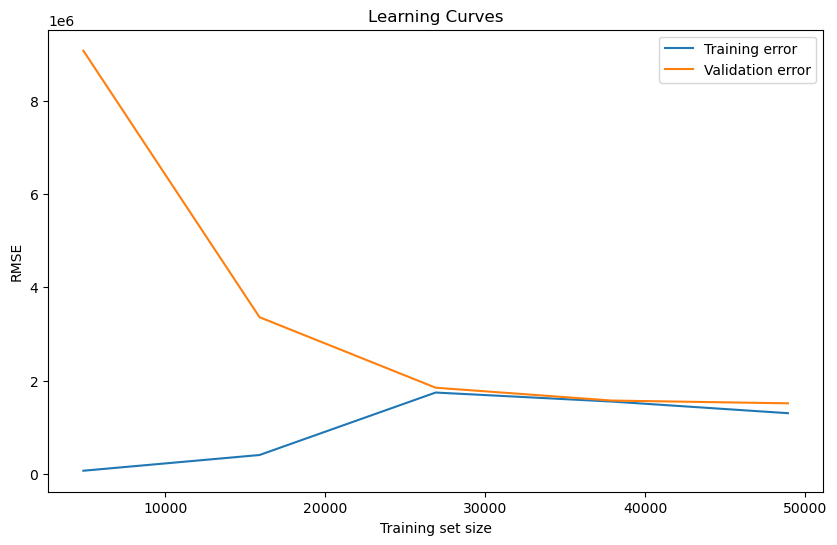

In [74]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(poly_model, X, y, cv=25, scoring='neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis=1)
val_scores_mean = -val_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, val_scores_mean, label='Validation error')
plt.ylabel('RMSE')
plt.xlabel('Training set size')
plt.title('Learning Curves')
plt.legend()
plt.show()

### Homosedasticity
Finally, in every linear model we have to make sure that the residuals follow a -kind of- normal distribution which we can see that even if narrows it seems to follow a normal distrubtion and as our dataset size is 50,000 we don't need p-value to test normality in the residuals. 

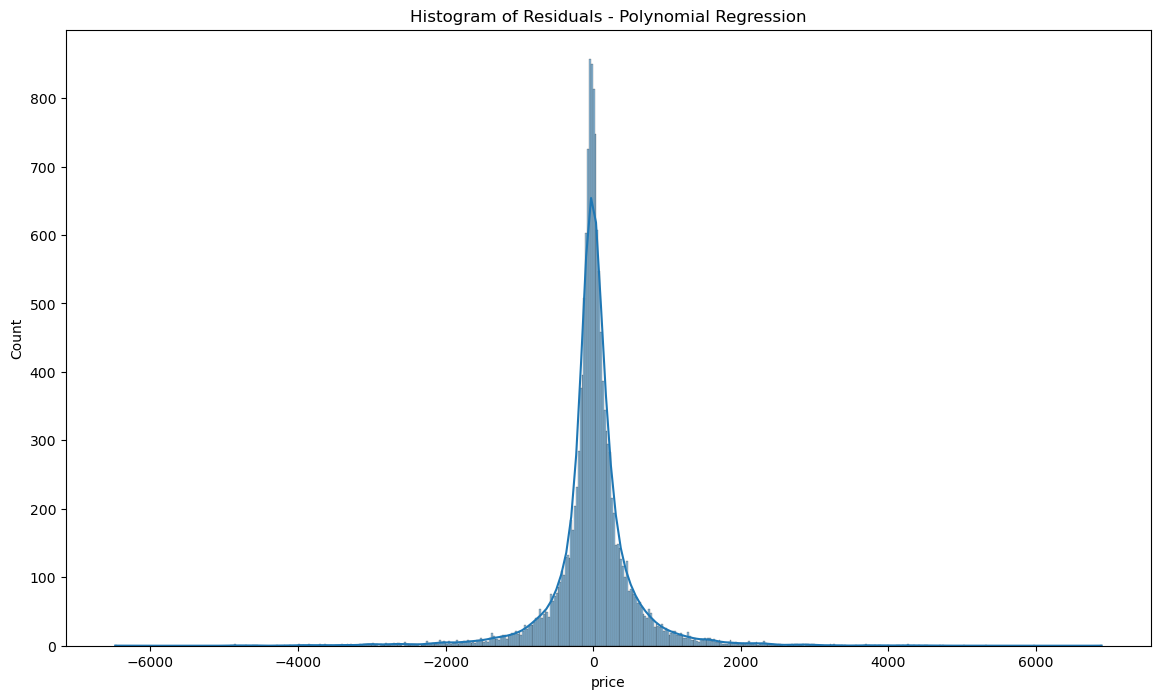

In [79]:
# Plot residuals for Polynomial Regression
plt.figure(figsize=(14, 8))
sns.histplot(poly_residuals, kde=True)
plt.title('Histogram of Residuals - Polynomial Regression')
plt.show()


In [78]:
# Shapiro-Wilk Test for normality
shapiro_test_poly = stats.shapiro(poly_residuals)
print(f'Shapiro-Wilk Test for Polynomial Regression Residuals: W={shapiro_test_poly[0]:.4f}, p-value={shapiro_test_poly[1]:.4f}')

Shapiro-Wilk Test for Polynomial Regression Residuals: W=0.7784, p-value=0.0000


c:\Users\rafae\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
